**Sensitivity analysis**
-------------------------

**Importing, loading... book keeping**

In [2]:
# import packages
import os
import sys
import numpy as np
import pandas as pd
import pcntoolkit
import seaborn as sns
import pickle
import glob
import shutil
import matplotlib.pyplot as plt

import xarray as xr
from glob import glob

# custom functions
code_dir = ('/home/barbora/Documents/Projects/Normative_Models/ESO/code')
os.chdir(code_dir)
import clinics_desc_functions as custom

In [3]:
# Where things are
project_dir = ('/home/barbora/Documents/Projects/Normative_Models')
pretrained_dir = os.path.join(project_dir,'ESO', 'braincharts')
models_dir = os.path.join(project_dir,'ESO', 'models', 'sensitivity')
data_dir = os.path.join(project_dir,'ESO', 'models', 'sensitivity', 'data')
images_dir = os.path.join(models_dir,'img')
os.makedirs(images_dir, exist_ok=True)

In [4]:
# get basic parameters for pretrained models
model_name, site_names, site_ids_tr, idp_ids = custom.pretrained_ini()

In [5]:
# Pick the preprocessing and load data
preproc = 'cs'

v1 = pd.read_csv(os.path.join(data_dir, 'all_'+preproc+'_1_qc.csv'), sep=' ', index_col=0)
v2 = pd.read_csv(os.path.join(data_dir, 'all_'+preproc+'_2_qc.csv'), sep=' ', index_col=0)

v1_pat = v1[v1['category']=='Patient']
v1_cont = v1[v1['category']=='Control']
v2_pat = v2[v2['category']=='Patient']
v2_cont = v2[v2['category']=='Control']

site_ids_te =  sorted(set(v1_pat['site'].to_list()))

**Running the sensitivity analysis**
-------------------------------------

In [5]:
###
# Train_test_split - split across sites, keep 30% as TESTING
###

from sklearn.model_selection import StratifiedShuffleSplit

#test_sizes = [0.20, 0.25, 0.30, 0.50, 0.70, 0.75, 0.80]
#stest_sizes = ['0.20', '0.25', '0.30', '0.50', '0.70', '0.75', '0.80']

test_sizes = [0.80]
stest_sizes = ['0.80']


for i, itest in enumerate(test_sizes):

    sss = StratifiedShuffleSplit(n_splits=5, test_size=itest, random_state=42)
    ifold = 1
    
    for train, test in sss.split(v1_cont.index,  v1_cont['sex']):

        iter_dir = os.path.join(os.path.join(models_dir,preproc,'fold_'+str(ifold)+'_test_'+stest_sizes[i]))
        os.makedirs(iter_dir, exist_ok=True)

        for ivisit in range(1,3):
            if ivisit == 1:
                df_te = v1_pat
                df_tec = v1_cont.iloc[test]
                df_ad = v1_cont.iloc[train]

            elif ivisit == 2:
                df_te = v2_pat
                df_tec = v1_cont.iloc[test]
                df_ad = v1_cont.iloc[train]

            visit_dir = os.path.join(iter_dir, 'V'+str(ivisit))
            os.makedirs(visit_dir, exist_ok=True)
            
            # create textfiles for checking
            df_te.to_csv(os.path.join(visit_dir, 'patients.csv'), sep=' ', index=True)
            df_tec.to_csv(os.path.join(visit_dir, 'controls_test.csv'), sep=' ', index=True)
            df_ad.to_csv(os.path.join(visit_dir, 'controls_adapt.csv'), sep=' ', index=True)

            custom.pretrained_adapt_controls(idp_ids, site_ids_tr, site_ids_te, pretrained_dir, visit_dir, df_ad, df_tec, df_te)

            # concatenate the results info a few textfiles
            filenames = ['Z_predict.txt', 'Z_conttest.txt', 'yhat_predict.txt', 'yhat_conttest.txt', 'ys2_predict.txt', 'ys2_conttest.txt',]

            for ifile in filenames:
                custom.idp_concat(visit_dir, ifile, idp_ids, ifile)

            temp1, measures = custom.idp_concat_quality(visit_dir, idp_ids, suffix='predict')
            temp1.to_csv(os.path.join(visit_dir, 'quality_predict.txt'), sep=' ', index=True)
            temp1, temp2 = custom.idp_concat_quality(visit_dir, idp_ids, suffix='conttest')
            temp1.to_csv(os.path.join(visit_dir, 'quality_conttest.txt'), sep=' ', index=True)

            # delete folders
            directories = [name for name in os.listdir(visit_dir) if os.path.isdir(os.path.join(visit_dir, name))]
            [shutil.rmtree(os.path.join(visit_dir,ifile)) for ifile in directories]
        
        ifold+=1




Running IDP 0 lh_G&S_frontomargin_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 lh_G&S_occipital_inf_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 lh_G&S_paracentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluati

_____________________

**Loading quality measures over folds**

In [39]:
import xarray as xr
from glob import glob

visit = 2
preproc = 'long'

quality_conttest = glob(models_dir+'/'+preproc+'/*/V'+str(visit)+'/quality_conttest.txt')

test_sizes = [0.2, 0.25, 0.3, 0.5, 0.7, 0.75, 0.8]
stest_sizes = ['0.20', '0.25', '0.30', '0.50', '0.70', '0.75', '0.80']

In [27]:
for isize in stest_sizes:
    twenty = [i for i in quality_conttest if isize in i]
    twenty = sorted(twenty)
    
    # load across folds and concatenate into nd array
    for i, ifile in enumerate(twenty):
        temp = pd.read_csv(ifile, sep=' ', index_col=0)
        if i == 0:
            pk = temp.to_numpy()
        else:
            pk = np.dstack((pk,temp.to_numpy()))
    
    # concat all nd-arrays into list
    if isize == stest_sizes[0]:
        quality = [pk]
    else:
        quality.append([pk])

# concatenation into xarray

pk1 = xr.DataArray(quality[0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk2 = xr.DataArray(quality[1][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk3 = xr.DataArray(quality[2][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk4 = xr.DataArray(quality[3][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk5 = xr.DataArray(quality[4][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk6 = xr.DataArray(quality[5][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk7 = xr.DataArray(quality[6][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])

pk = xr.concat([pk1,pk2,pk3,pk4,pk5,pk6,pk7], pd.Index(test_sizes, name = 'test_size'))

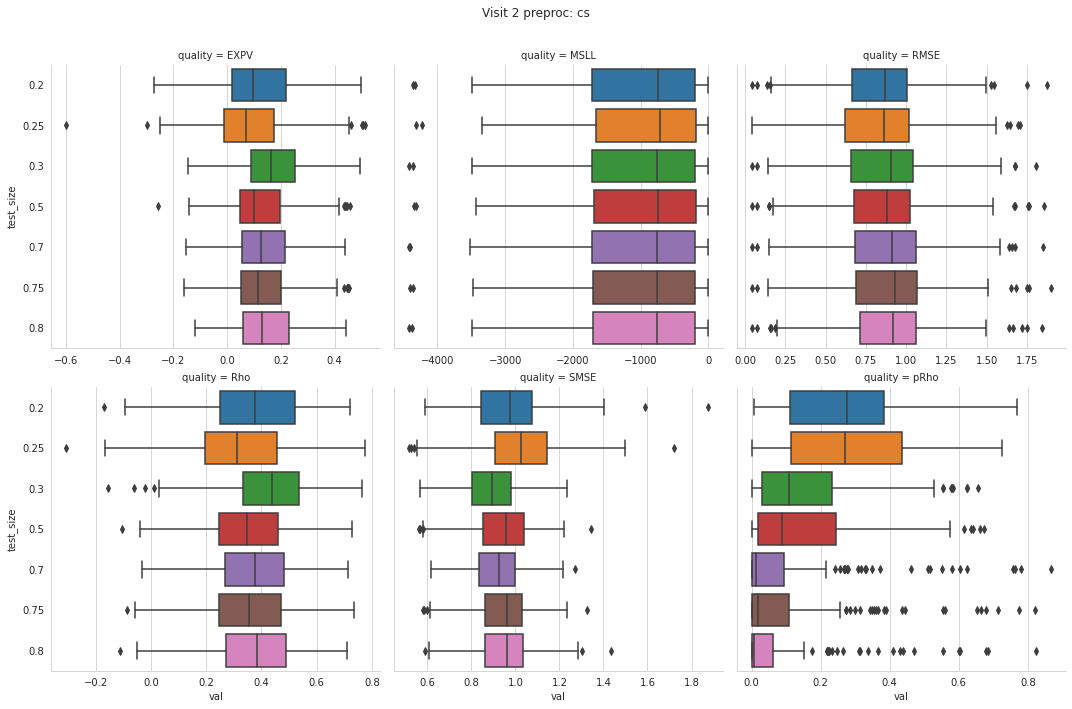

In [19]:
# Plot mean quality across all test sizes
to_plot = pk.mean(axis=3).to_dataframe(name='val')

to_plot['test_size'] = to_plot.index.get_level_values(0).astype("category")
to_plot['roi'] = to_plot.index.get_level_values(1).astype("category")
to_plot['quality'] = to_plot.index.get_level_values(2).astype("category")

sns.set_style("whitegrid")
facet_kws = sns.catplot(data=to_plot, x='val', y='test_size', col='quality', kind='box', col_wrap=3, sharex=False)

facet_kws.fig.subplots_adjust(top=0.9) 
facet_kws.fig.suptitle('Visit '+str(visit)+' preproc: '+preproc)

plt.savefig(os.path.join(images_dir, 'bp_conttest_quality_V'+str(visit)+'_'+preproc))


Correlations across mean patients scores

In [40]:
import xarray as xr
from glob import glob

quality_conttest = glob(models_dir+'/'+preproc+'/*/V'+str(visit)+'/Z_predict.txt')
glob_subjects = glob(models_dir+'/'+preproc+'/*/V'+str(visit)+'/patients.csv')
patients = pd.read_csv(glob_subjects[0], sep=' ', index_col=0)

stest_sizes = ['0.20', '0.25', '0.30', '0.50', '0.70', '0.75', '0.80']

In [41]:
for isize in stest_sizes:
    twenty = [i for i in quality_conttest if isize in i]
    twenty = sorted(twenty)
    
    # load across folds and concatenate into nd array
    for i, ifile in enumerate(twenty):
        temp = pd.read_csv(ifile, sep=' ', index_col=0)
        if i == 0:
            pk = temp.to_numpy()
        else:
            pk = np.dstack((pk,temp.to_numpy()))
    
    # concat all nd-arrays into list
    if isize == stest_sizes[0]:
        quality = [pk]
    else:
        quality.append([pk])



In [42]:
# concatenation into xarray

metric1 = 'subject'
metric2 = 'roi'

pk1 = xr.DataArray(quality[0],    [(metric1,list(patients.index)), (metric2, list(temp.columns)), ("fold", range(1,6))])
pk2 = xr.DataArray(quality[1][0], [(metric1,list(patients.index)), (metric2, list(temp.columns)), ("fold", range(1,6))])
pk3 = xr.DataArray(quality[2][0], [(metric1,list(patients.index)), (metric2, list(temp.columns)), ("fold", range(1,6))])
pk4 = xr.DataArray(quality[3][0], [(metric1,list(patients.index)), (metric2, list(temp.columns)), ("fold", range(1,6))])
pk5 = xr.DataArray(quality[4][0], [(metric1,list(patients.index)), (metric2, list(temp.columns)), ("fold", range(1,6))])
pk6 = xr.DataArray(quality[5][0], [(metric1,list(patients.index)), (metric2, list(temp.columns)), ("fold", range(1,6))])
pk7 = xr.DataArray(quality[6][0], [(metric1,list(patients.index)), (metric2, list(temp.columns)), ("fold", range(1,6))])


pk = xr.concat([pk1,pk2,pk3,pk4,pk5,pk6,pk7], pd.Index(test_sizes, name = 'test_size'))

In [43]:
subject_mean = pk.mean(axis=3)

/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/barbora/In

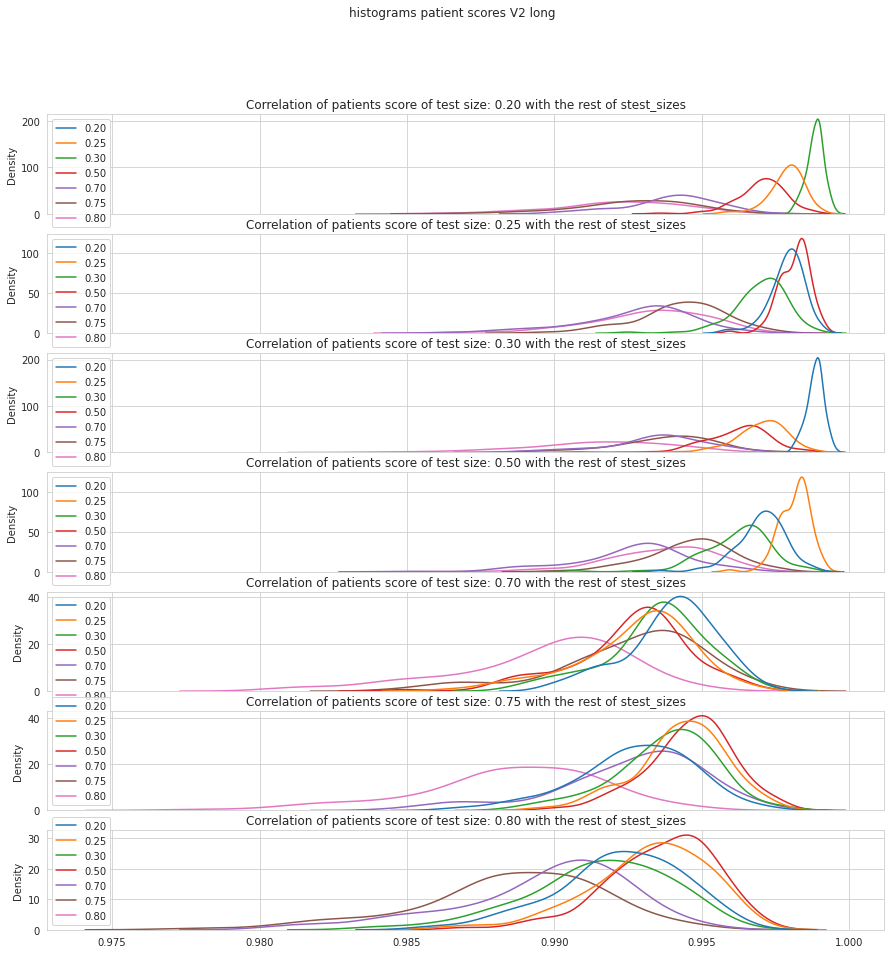

In [44]:
fig, ax = plt.subplots(len(stest_sizes), 1, figsize=(15,15), sharex=True)

for i, iplot in enumerate(stest_sizes):
    tdata = np.empty([ len(stest_sizes), len(pk['subject']) ])
    for j, jplot in enumerate(stest_sizes):
        (c, p ,pplot) = custom.spearman_matrices(subject_mean.sel(test_size = iplot).T, subject_mean.sel(test_size = jplot).T)
        tdata[j,:] = np.diag(c)
    
    tdata = pd.DataFrame(tdata, index=stest_sizes, columns=pk["subject"])
    sns.kdeplot(data = tdata.T, ax=ax[i])
    ax[i].set_title('Correlation of patients score of test size: '+iplot+' with the rest of stest_sizes')

fig.suptitle('histograms patient scores V'+str(visit)+'                     '+preproc)
plt.savefig(os.path.join(images_dir,'hist_patscores_testsizes_V'+str(visit)+'_'+preproc))

**We need to break this down even more**

In [220]:
import xarray as xr
from glob import glob

visit = 2
preproc = 'cs'

quality_conttest = glob(models_dir+'/'+preproc+'/*/V'+str(visit)+'/quality_conttest.txt')

test_sizes = [0.2, 0.25, 0.3, 0.5, 0.7, 0.75, 0.8]
stest_sizes = ['0.20', '0.25', '0.30', '0.50', '0.70', '0.75', '0.80']

In [221]:
for isize in stest_sizes:
    twenty = [i for i in quality_conttest if isize in i]
    twenty = sorted(twenty)
    
    # load across folds and concatenate into nd array
    for i, ifile in enumerate(twenty):
        temp = pd.read_csv(ifile, sep=' ', index_col=0)
        if i == 0:
            pk = temp.to_numpy()
        else:
            pk = np.dstack((pk,temp.to_numpy()))
    
    # concat all nd-arrays into list
    if isize == stest_sizes[0]:
        quality = [pk]
    else:
        quality.append([pk])

# concatenation into xarray

pk1 = xr.DataArray(quality[0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk2 = xr.DataArray(quality[1][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk3 = xr.DataArray(quality[2][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk4 = xr.DataArray(quality[3][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk5 = xr.DataArray(quality[4][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk6 = xr.DataArray(quality[5][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])
pk7 = xr.DataArray(quality[6][0], [("roi",list(temp.index)), ("quality", list(temp.columns)), ("fold", range(1,6))])

pk = xr.concat([pk1,pk2,pk3,pk4,pk5,pk6,pk7], pd.Index(test_sizes, name = 'test_size'))

In [222]:
pk1_long = pk
pk2_long = pk
pk1_cs = pk
pk2_cs = pk

In [28]:
# Save concatenated xarray data
quality = xr.concat([pk1_long, pk2_long, pk1_cs, pk2_cs], pd.Index(['pk1_long', 'pk2_long', 'pk1_cs', 'pk2_cs'], name="dataset"))
quality.to_netcdf(os.path.join(data_dir, 'quality_concat'), mode='w')

**Load processed data**

In [705]:
# Load everything (that concerns quality)
quality = xr.load_dataset(os.path.join(data_dir, 'quality_concat'))
quality = quality.rename({'__xarray_dataarray_variable__': 'val'})

In [ ]:
sns.set_theme(style="whitegrid", rc={"axes.facecolor": (1, 1, 1, 1)})
measures = list(quality['quality'].to_numpy())

for imeasure in measures:

    nplots = 5
    nfigures = 0

    for i, idp in enumerate(idp_ids[175:]):
        
        if np.mod(i,nplots**2) ==0:        
            fig,ax = plt.subplots(nplots,nplots, figsize=(15,15), sharex = True, sharey=True)

            if i!=0:
                nfigures+=1
            
        
        x = int(np.floor(i/nplots))-(5*nfigures)
        y = np.mod(i,nplots)

        to_plot = quality.sel(roi=idp, quality=imeasure).to_dataframe()
        to_plot['dataset'] = to_plot.index.get_level_values(0).astype('category')
        to_plot['test_size'] = to_plot.index.get_level_values(1).astype('category')
        to_plot['fold'] = to_plot.index.get_level_values(2).astype('category')

        ax[x,y] = sns.swarmplot(data=to_plot, x='val', y='test_size', hue='dataset', ax=ax[x,y])
        
        ax[x,y].set_ylabel('')
        ax[x,y].set_title(idp)
        ax[x,y].legend([],[],frameon=False)

        if (np.mod(i,nplots**2) == (nplots**2)-1) | (i==len(idp_ids)-1):
            sns.despine(fig)
            plt.tight_layout()
            #plt.savefig(os.path.join(images_dir,'quality_'+imeasure+'_kfoldspokus'+str(nfigures)))
            #plt.close()
    

In [163]:
# Load surface areas, to use it as a covariate
surf_cs_1 = pd.read_csv(os.path.join(data_dir, 'all_cs_SurfArea_1_qc.csv'), sep=' ', index_col=0)
surf_cs_2 = pd.read_csv(os.path.join(data_dir, 'all_cs_SurfArea_2_qc.csv'), sep=' ', index_col=0)
surf_long_1 = pd.read_csv(os.path.join(data_dir, 'all_long_SurfArea_1_qc.csv'), sep=' ', index_col=0)
surf_long_2 = pd.read_csv(os.path.join(data_dir, 'all_long_SurfArea_2_qc.csv'), sep=' ', index_col=0)

surface = [surf_long_1, surf_long_2, surf_cs_1, surf_cs_2]

In [218]:
# Attaching surface areas to the quality data
for i, isurface in enumerate(surface):
    isurface.columns = [i.replace('_SurfArea', '_thickness') for i in isurface.columns]
    surface[i] = isurface

sa_names = ['surf_cs_1', 'surf_cs_2', 'surf_long_1', 'surf_long_2']
for i in range(0,4):
    if i == 0:
        df = pd.DataFrame(surface[i][surface[i]['category'] == 'Control'][idp_ids].mean(), columns=[sa_names[i]])
    else:
        temp = pd.DataFrame(surface[i][surface[i]['category'] == 'Control'][idp_ids].mean(), columns=[sa_names[i]])
        df = pd.concat([df,temp], axis=1, join='inner')
        df.index.name = 'roi'

temp = xr.DataArray(df.to_numpy(), [("roi",list(df.index)), ("surf_area", list(df.columns))])
quality["SurfArea"] = temp
quality["logSurfArea"] = np.log(temp)

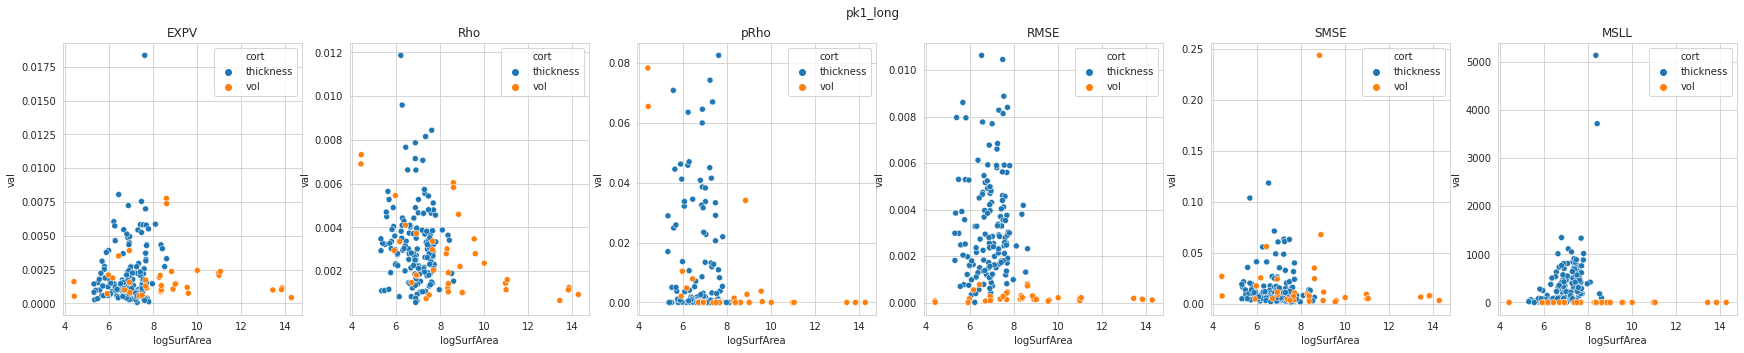

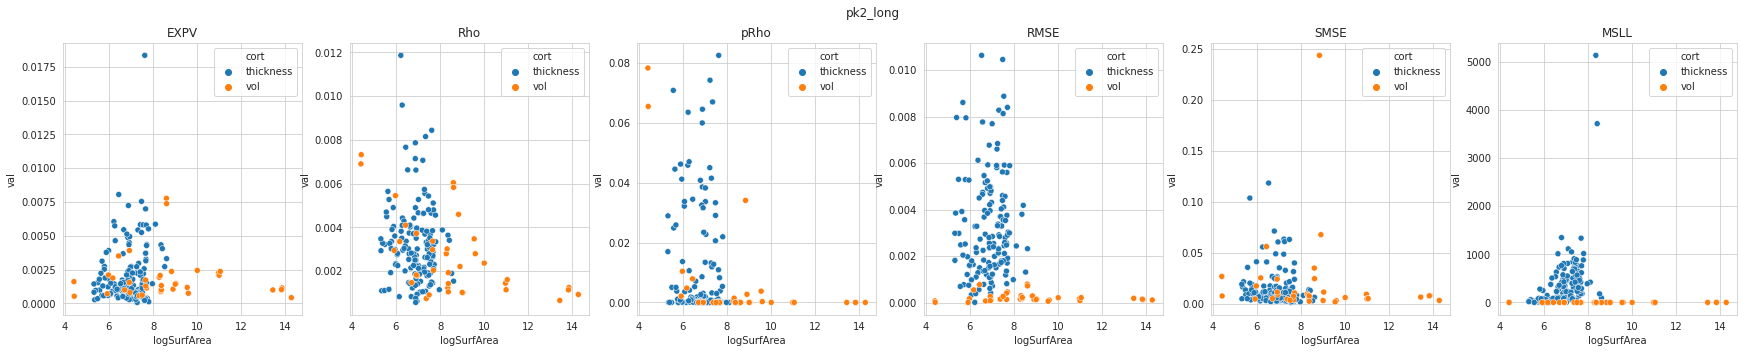

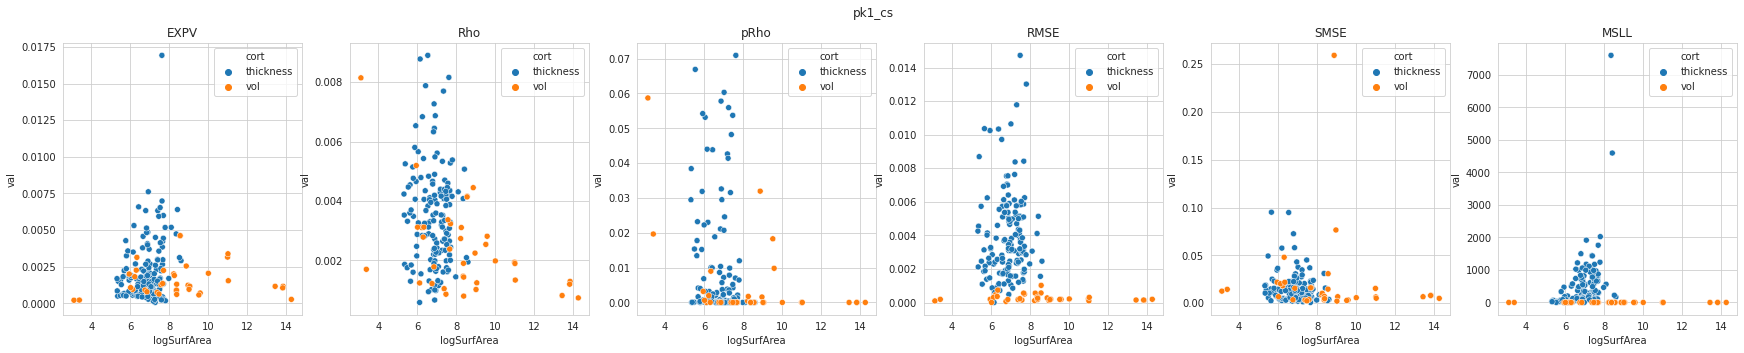

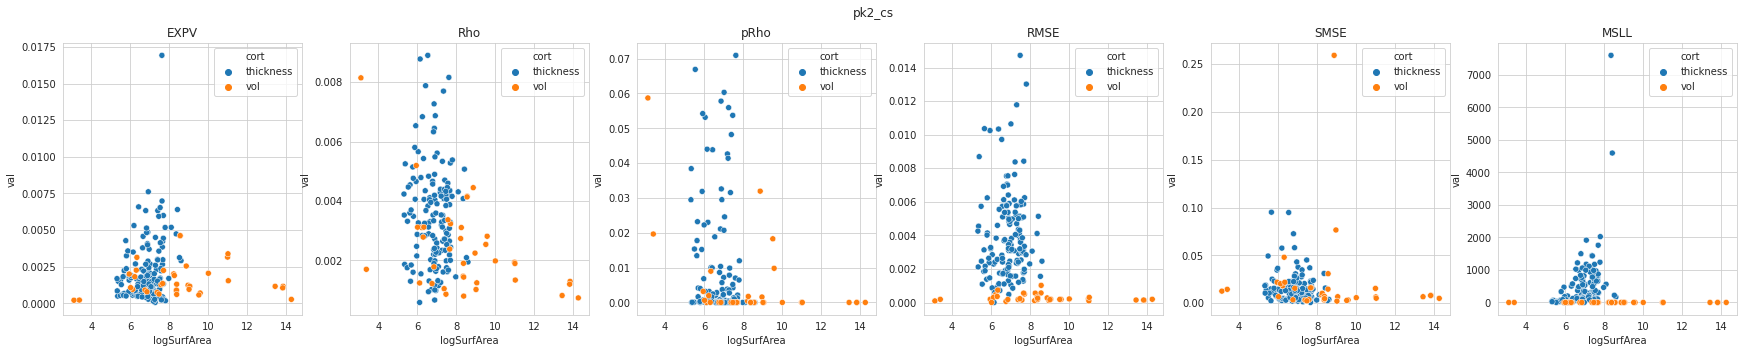

In [330]:
# plotting (potential) dependence of quality and surface area
cort = [i for i in idp_ids if 'thickness' in i]
sns.set_style("whitegrid", rc={"axes.facecolor": (1, 1, 1, 1)})


for idataset in range(0,4):
    fig, ax = plt.subplots(1,6, figsize=(30,5))
    st = list(quality['dataset'].to_numpy())[idataset]
    fig.suptitle(st)
    for iplot,iqual in enumerate(list(quality['quality'].to_numpy())):

        #pkx = quality.sel(test_size=[0.7, 0.75, 0.8], quality =iqual, dataset='pk1_long').stack(z=('fold', 'test_size'))['val'].max(axis=1) - quality.sel(test_size=[0.7, 0.75, 0.8], quality =iqual, dataset='pk1_long').stack(z=('fold', 'test_size'))['val'].min(axis=1)
        pkx = quality.sel(test_size=[0.7, 0.75, 0.8], quality =iqual).isel(dataset=idataset).stack(z=('fold', 'test_size'))['val'].var(axis=1)
        pky = quality.isel(surf_area=idataset)['logSurfArea']

        pk = pd.concat([pkx.to_dataframe(), pky.to_dataframe()], axis=1)

        pk['cort'] = 'vol'
        pk.loc[cort, 'cort']  = 'thickness'

        sns.scatterplot(data=pk, x='logSurfArea', y='val', hue='cort', ax = ax[iplot])   
        ax[iplot].set_title(iqual)
        #ax[iplot].set_xlim(0,5000)
    
    plt.savefig(os.path.join(images_dir, 'scatter_log_'+st+'_quality'))

Processing subjects

In [690]:
import xarray as xr
from glob import glob

visit = 2
preproc = 'cs'

z_test_f = glob(models_dir+'/'+preproc+'/*/V'+str(visit)+'/Z_predict.txt')
csv_patients = pd.read_csv('/home/barbora/Documents/Projects/Normative_Models/ESO/models/sensitivity/cs/fold_1_test_0.20/V1/patients.csv', sep=' ', index_col=0)

test_sizes = [0.2, 0.25, 0.3, 0.5, 0.7, 0.75, 0.8]
stest_sizes = ['0.20', '0.25', '0.30', '0.50', '0.70', '0.75', '0.80']

In [560]:
for isize in stest_sizes:
    twenty = [i for i in z_test_f if isize in i]
    twenty = sorted(twenty)
    
    # load across folds and concatenate into nd array
    for i, ifile in enumerate(twenty):
        temp = pd.read_csv(ifile, sep=' ', index_col=0)
        if i == 0:
            pk = temp.to_numpy()
        else:
            pk = np.dstack((pk,temp.to_numpy()))
    
    # concat all nd-arrays into list
    if isize == stest_sizes[0]:
        z_test = [pk]
    else:
        z_test.append([pk])



In [561]:
# concatenation into xarray

pk1 = xr.DataArray(z_test[0], [("subject", list(patients.index)), ("roi",list(temp.columns)), ("fold", range(1,6))])
pk2 = xr.DataArray(z_test[1][0], [("subject", list(patients.index)),("roi",list(temp.columns)),("fold", range(1,6))])
pk3 = xr.DataArray(z_test[2][0], [("subject", list(patients.index)),("roi",list(temp.columns)),("fold", range(1,6))])
pk4 = xr.DataArray(z_test[3][0], [("subject", list(patients.index)),("roi",list(temp.columns)),("fold", range(1,6))])
pk5 = xr.DataArray(z_test[4][0], [("subject", list(patients.index)),("roi",list(temp.columns)),("fold", range(1,6))])
pk6 = xr.DataArray(z_test[5][0], [("subject", list(patients.index)),("roi",list(temp.columns)),("fold", range(1,6))])
pk7 = xr.DataArray(z_test[6][0], [("subject", list(patients.index)),("roi",list(temp.columns)),("fold", range(1,6))])

pk = xr.concat([pk1,pk2,pk3,pk4,pk5,pk6,pk7], pd.Index(test_sizes, name = 'test_size'))

In [562]:
pk2_cs = pk

In [563]:
pk1_long = pk
pk2_long = pk
pk1_cs = pk
pk2_cs = pk

In [564]:
patients = xr.concat([pk1_long, pk2_long, pk1_cs, pk2_cs], pd.Index(['pk1_long', 'pk2_long', 'pk1_cs', 'pk2_cs'], name="dataset"))
patients.to_netcdf(os.path.join(data_dir, 'z_patients'), mode='w')


In [565]:
patients = xr.load_dataset(os.path.join(data_dir, 'z_patients'))
patients = patients.rename({'__xarray_dataarray_variable__': 'val'})

In [566]:
# Load surface areas, to use it as a covariate
surf_cs_1 = pd.read_csv(os.path.join(data_dir, 'all_cs_SurfArea_1_qc.csv'), sep=' ', index_col=0)
surf_cs_2 = pd.read_csv(os.path.join(data_dir, 'all_cs_SurfArea_2_qc.csv'), sep=' ', index_col=0)
surf_long_1 = pd.read_csv(os.path.join(data_dir, 'all_long_SurfArea_1_qc.csv'), sep=' ', index_col=0)
surf_long_2 = pd.read_csv(os.path.join(data_dir, 'all_long_SurfArea_2_qc.csv'), sep=' ', index_col=0)

surface = [surf_long_1, surf_long_2, surf_cs_1, surf_cs_2]
#dataset = ['surf1_long', 'surf2_long', 'surf1_cs', 'surf2_cs']


# Attaching surface areas to the quality data
for i,isurf in enumerate(surface):
    isurf = isurf[isurf['category'] == 'Patient']
    isurf.index.name='subject'
    isurf.columns = [i.replace('_SurfArea', '_thickness') for i in isurf.columns]
    surface[i] = isurf


In [570]:
pk1 = xr.DataArray(surface[0][idp_ids].to_numpy(), [("subject", list(surface[0].index)), ("roi",idp_ids)])
pk2 = xr.DataArray(surface[1][idp_ids].to_numpy(), [("subject", list(surface[1].index)), ("roi",idp_ids)])
pk3 = xr.DataArray(surface[2][idp_ids].to_numpy(), [("subject", list(surface[2].index)), ("roi",idp_ids)])
pk4 = xr.DataArray(surface[3][idp_ids].to_numpy(), [("subject", list(surface[3].index)), ("roi",idp_ids)])

pk = xr.concat([pk1,pk2,pk3,pk4], pd.Index(list(patients['dataset'].to_numpy()), name = 'dataset'))
patients['surface'] = pk

In [572]:
patients.to_netcdf(os.path.join(data_dir, 'z_patients'), mode='w')
patients = xr.load_dataset(os.path.join(data_dir, 'z_patients'))


**Analysis**

In [415]:
pk = patients.sel(roi=idp_ids[0], dataset='pk1_long')['val'].to_dataframe()
pk['test_size'] = pk.index.get_level_values(0).astype('category')
pk['subject'] = pk.index.get_level_values(1).astype('category')

/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 57.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 65.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/barbora/Instalacky/yes/envs/PCN/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 74.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/barbor

<AxesSubplot:xlabel='val', ylabel='subject'>

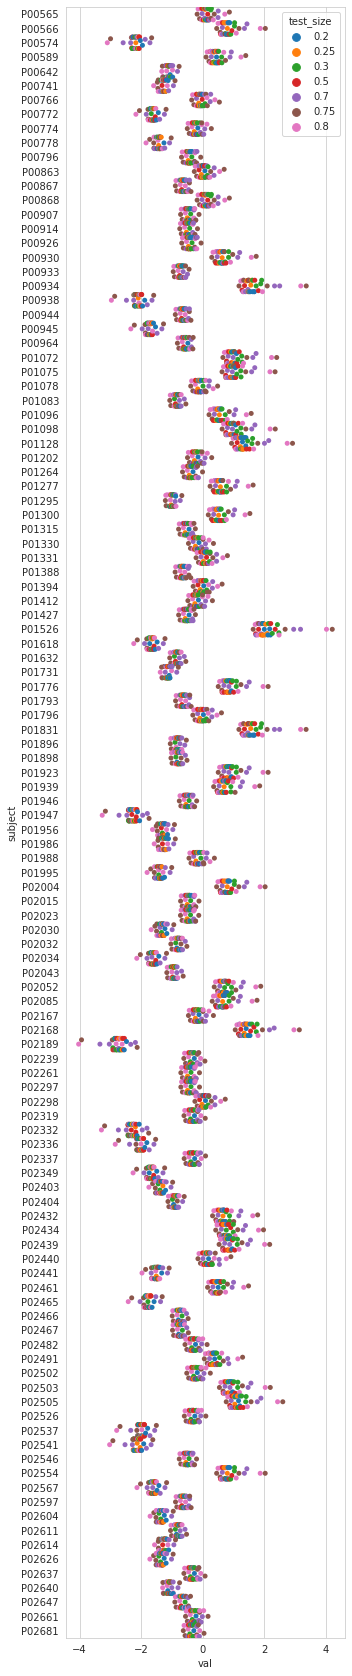

In [417]:
fig,ax = plt.subplots(figsize=(5,30))
sns.swarmplot(data=pk, x='val', y='subject', hue='test_size',ax=ax)
#ax[x,y] = sns.swarmplot(data=to_plot, x='val', y='test_size', hue='dataset', ax=ax[x,y])

In [610]:
#pk = patients.sel(dataset='pk1_long', roi=idp_ids[0]).isel(test_size = 0).var(dim='fold')['val'].to_dataframe()
pky = patients.sel(dataset='pk1_long', roi=idp_ids[0]).isel(test_size = 0).var(dim='fold')['val']
pkx = patients.sel(dataset='pk1_long', roi=idp_ids[0])['surface']

In [677]:
sns.set_theme(style="whitegrid", rc={"axes.facecolor": (1, 1, 1, 1)})
nplots = 5
nfigures = 0

for i, idp in enumerate(idp_ids):
    
    if np.mod(i,nplots**2) ==0:        
        fig,ax = plt.subplots(nplots,nplots, figsize=(15,15), sharey=True)

        if i!=0:
            nfigures+=1
        
    
    x = int(np.floor(i/nplots))-(5*nfigures)
    y = np.mod(i,nplots)

    to_plot = patients.sel(roi=idp).isel(test_size = 0).var(dim=('fold'))['val'].to_dataframe()
    to_plot = pd.concat([to_plot,pd.DataFrame(patients.sel(roi=idp)['surface'].to_dataframe()['surface'])], axis =1)
    to_plot['dataset'] = to_plot.index.get_level_values(0).astype("category")
    ax[x,y] = sns.scatterplot(data=to_plot[to_plot['roi']==idp], x ='surface', y='val', hue='dataset', ax=ax[x,y], hue_order=['pk1_long', 'pk2_long','pk1_cs', 'pk2_cs'])
    
    ax[x,y].set_ylabel('')
    ax[x,y].set_title(idp)
    ax[x,y].legend([],[],frameon=False)

    if (np.mod(i,nplots**2) == (nplots**2)-1) | (i == len(idp_ids)-1):
        sns.despine
        plt.tight_layout()
        plt.savefig(os.path.join(images_dir,'prediction_'+'02+'+str(nfigures)))
        plt.close()


In [693]:
#xr.DataArray(surface[0][idp_ids].to_numpy(), [("subject", list(surface[0].index)), ("roi",idp_ids)])
xr.DataArray(csv_patients[['sex','age']].to-numpy(), [("subject", list(csv_patients.index)), ("clinics", ['sex', 'age'])])

AttributeError: 'DataFrame' object has no attribute 'to'

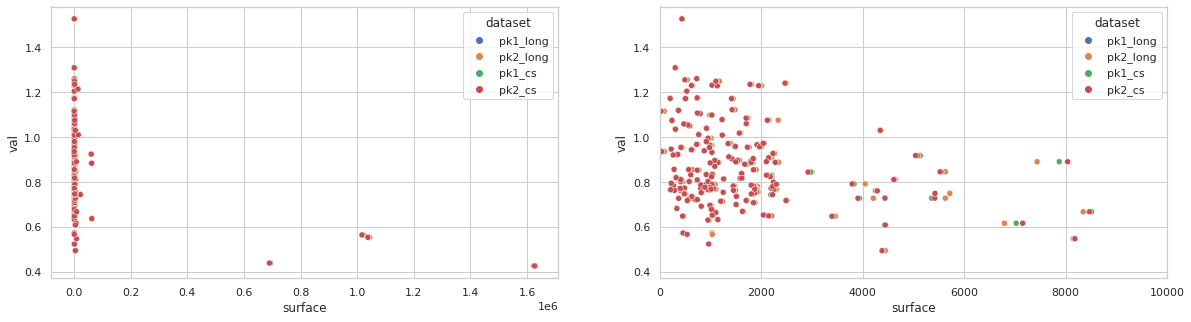

In [708]:
for test_sizes in range(0,1):
    to_plot = patients.isel(test_size = test_sizes).var(['fold','subject'])['val'].to_dataframe()
    to_plot = pd.concat([to_plot,patients['surface'].mean('subject').to_dataframe()], axis=1)
    to_plot['dataset'] = to_plot.index.get_level_values(0)

    fig,ax = plt.subplots(1,2,figsize=(20,5))
    ax[0] = sns.scatterplot(data=to_plot, x='surface', y='val', hue='dataset', hue_order=['pk1_long', 'pk2_long','pk1_cs', 'pk2_cs'], ax=ax[0])
    ax[1] = sns.scatterplot(data=to_plot, x='surface', y='val', hue='dataset', hue_order=['pk1_long', 'pk2_long','pk1_cs', 'pk2_cs'], ax=ax[1])
    ax[1].set_xlim(0,10000)
    #fig.suptitle('Average surface area vs average variance in IDP across folds and subjects (test set ='+str(stest_sizes[test_sizes])+')')
    #plt.savefig(os.path.join(images_dir, 'scatterplot_averages_'+str(test_sizes)))



In [725]:
to_plot_small = to_plot[to_plot['dataset']=='pk1_long']
to_plot_small['roi'] = to_plot_small.index.get_level_values(1)
to_plot_small.index = to_plot_small['roi']
to_plot_small = pd.DataFrame(to_plot_small['val'])

/tmp/ipykernel_4559/2132661294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_plot_small['roi'] = to_plot_small.index.get_level_values(1)


In [738]:
import nilearn.plotting as plotting
(data_mapping, view, fs_plot, fs_sulc) = custom.prepare_destrieux_plotting(to_plot_small, 'r', method='counts')
plotting.view_surf(fs_plot, data_mapping, threshold=None, cmap='Reds', bg_map=fs_sulc, symmetric_cmap=False, vmax =2).save_as_html(os.path.join(images_dir, 'free_average_var_r.html'))

In [739]:
(data_mapping, view, fs_plot, fs_sulc) = custom.prepare_destrieux_plotting(to_plot_small, 'l', method='counts')
plotting.view_surf(fs_plot, data_mapping, threshold=None, cmap='Reds', bg_map=fs_sulc, symmetric_cmap=False, vmax=2).save_as_html(os.path.join(images_dir, 'free_average_var_l.html'))

In [6]:
###
# Train_test_split - split across sites, keep 30% as TESTING
###

from sklearn.model_selection import StratifiedShuffleSplit

#test_sizes = [0.20, 0.25, 0.30, 0.50, 0.70, 0.75, 0.80]
#stest_sizes = ['0.20', '0.25', '0.30', '0.50', '0.70', '0.75', '0.80']

test_sizes = [0.80]
stest_sizes = ['0.80']


for i, itest in enumerate(test_sizes):

    sss = StratifiedShuffleSplit(n_splits=5, test_size=itest, random_state=42)
    ifold = 1
    
    for train, test in sss.split(v1_cont.index,  v1_cont['sex']):

        iter_dir = os.path.join(os.path.join(models_dir,preproc,'POKUS_'+str(ifold)+'_test_'+stest_sizes[i]))
        os.makedirs(iter_dir, exist_ok=True)

        for ivisit in range(1,3):
            if ivisit == 1:
                df_te = v1_pat
                df_tec = v1_cont.iloc[test]
                df_ad = v1_cont.iloc[train]

            elif ivisit == 2:
                df_te = v2_pat
                df_tec = v1_cont.iloc[test]
                df_ad = v1_cont.iloc[train]

            visit_dir = os.path.join(iter_dir, 'V'+str(ivisit))
            os.makedirs(visit_dir, exist_ok=True)
            
            # create textfiles for checking
            df_te.to_csv(os.path.join(visit_dir, 'patients.csv'), sep=' ', index=True)
            df_tec.to_csv(os.path.join(visit_dir, 'controls_test.csv'), sep=' ', index=True)
            df_ad.to_csv(os.path.join(visit_dir, 'controls_adapt.csv'), sep=' ', index=True)

            custom.pretrained_adapt_controls(idp_ids, site_ids_tr, site_ids_te, pretrained_dir, visit_dir, df_ad, df_tec, df_te)

            # concatenate the results info a few textfiles
            filenames = ['Z_predict.txt', 'Z_conttest.txt', 'yhat_predict.txt', 'yhat_conttest.txt', 'ys2_predict.txt', 'ys2_conttest.txt',]

            for ifile in filenames:
                custom.idp_concat(visit_dir, ifile, idp_ids, ifile)

            temp1, measures = custom.idp_concat_quality(visit_dir, idp_ids, suffix='predict')
            temp1.to_csv(os.path.join(visit_dir, 'quality_predict.txt'), sep=' ', index=True)
            temp1, temp2 = custom.idp_concat_quality(visit_dir, idp_ids, suffix='conttest')
            temp1.to_csv(os.path.join(visit_dir, 'quality_conttest.txt'), sep=' ', index=True)

            # delete folders
            directories = [name for name in os.listdir(visit_dir) if os.path.isdir(os.path.join(visit_dir, name))]
            [shutil.rmtree(os.path.join(visit_dir,ifile)) for ifile in directories]
        
        ifold+=1




Running IDP 0 lh_G&S_frontomargin_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 lh_G&S_occipital_inf_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 lh_G&S_paracentral_thickness :
Some sites missing from the training data. Adapting model
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluati